## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load the dataset and visualize

In [2]:
import pathlib
dataset_url = "./images"

data_dir = pathlib.Path(dataset_url)
data_dir

PosixPath('images')

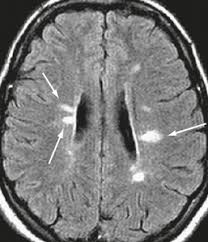

In [3]:
brains = list(data_dir.glob('*/*'))
PIL.Image.open(str(brains[0]))

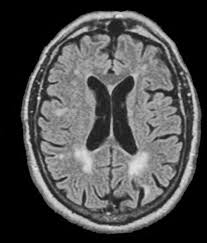

In [4]:
PIL.Image.open(str(brains[1]))

And some tulips:

# Load using keras.preprocessing


In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
data_dir

PosixPath('images')

Using 80% of the images for training, and the rest for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 247 files belonging to 2 classes.
Using 198 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 247 files belonging to 2 classes.
Using 49 files for validation.


### Class names:

In [9]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


### Visualize first 6 images



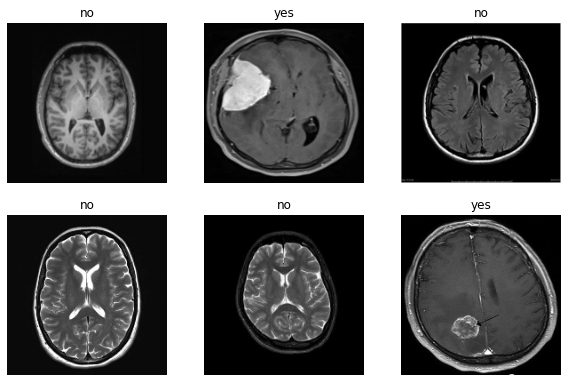

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Improving latency and throughput


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

## Scale the data

Numbers showing the RGB values are between 0 and 255 which are not good for neutal networks. We will add a layer to scale these values.

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Create the model

Numbers showing the RGB values are between 0 and 255 which are not good for neural networks. We will first add a layer to scale these values. Then, we will use three convolution blocks with a max pool layer in each of them. `MaxPooling2D` is class in `Keras` that pulls maximum number in a `n`x`n` window to reduce the size of the immage (to decrease computation complexity).


In [16]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

## Train the model

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 4s 412ms/step - loss: 1.1059 - accuracy: 0.5810 - val_loss: 0.5055 - val_accuracy: 0.8571
Epoch 2/10
7/7 [==============================] - 2s 260ms/step - loss: 0.5764 - accuracy: 0.7670 - val_loss: 0.3529 - val_accuracy: 0.8980
Epoch 3/10
7/7 [==============================] - 2s 260ms/step - loss: 0.5268 - accuracy: 0.7488 - val_loss: 0.3030 - val_accuracy: 0.8980
Epoch 4/10
7/7 [==============================] - 2s 269ms/step - loss: 0.4956 - accuracy: 0.7591 - val_loss: 0.3035 - val_accuracy: 0.8776
Epoch 5/10
7/7 [==============================] - 2s 270ms/step - loss: 0.4550 - accuracy: 0.7765 - val_loss: 0.2657 - val_accuracy: 0.9184
Epoch 6/10
7/7 [==============================] - 2s 278ms/step - loss: 0.3340 - accuracy: 0.8798 - val_loss: 0.3774 - val_accuracy: 0.8367
Epoch 7/10
7/7 [==============================] - 2s 268ms/step - loss: 0.2880 - accuracy: 0.9061 - val_loss: 0.2373 - val_accuracy: 0.8776
Epoch 8/10
7/7 [====

## Visualize loss and accruracy plots

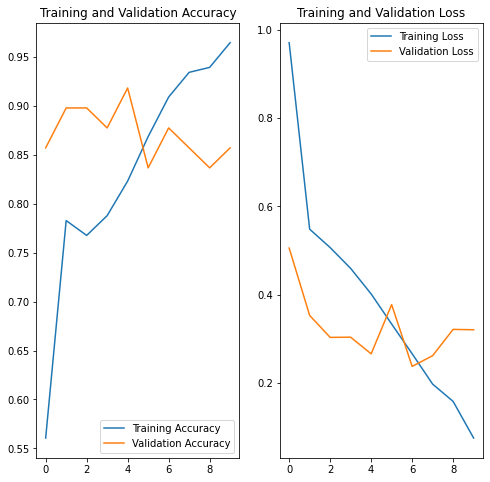

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Above figure shows a large gap between train and validation in accuracy curve. This large gap together with high accuracy of training are the signs of overfitting. In order to reduce overfitting, we will increase number of observations (number of brain scan pictures) synthetically which is called data augmentation. Also we will randomly drop out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout decreases the complexity of the network in training and thus helps avoid overfitting.

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Follwoing pictures are examples of augmented brain scans which are generated from a single image.

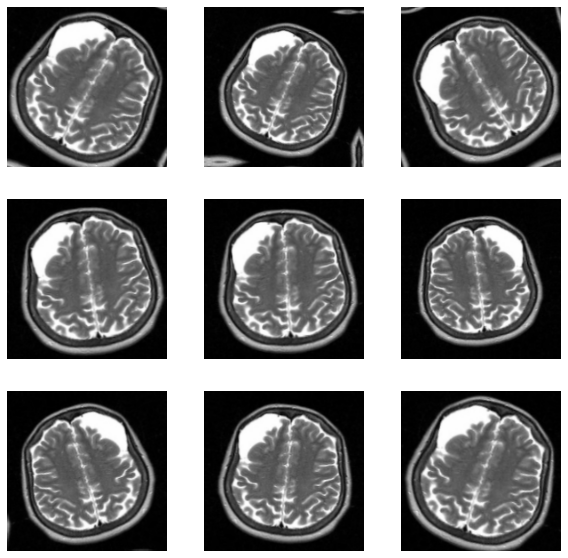

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [23]:
num_classes = 2
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [26]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 3s 381ms/step - loss: 0.6826 - accuracy: 0.7205 - val_loss: 0.4295 - val_accuracy: 0.8980
Epoch 2/10
7/7 [==============================] - 2s 316ms/step - loss: 0.5945 - accuracy: 0.6605 - val_loss: 0.4621 - val_accuracy: 0.8367
Epoch 3/10
7/7 [==============================] - 2s 321ms/step - loss: 0.5721 - accuracy: 0.7345 - val_loss: 0.3501 - val_accuracy: 0.8776
Epoch 4/10
7/7 [==============================] - 2s 322ms/step - loss: 0.5721 - accuracy: 0.6945 - val_loss: 0.3704 - val_accuracy: 0.8571
Epoch 5/10
7/7 [==============================] - 2s 381ms/step - loss: 0.5390 - accuracy: 0.7494 - val_loss: 0.3794 - val_accuracy: 0.8571
Epoch 6/10
7/7 [==============================] - 2s 331ms/step - loss: 0.4891 - accuracy: 0.7770 - val_loss: 0.2975 - val_accuracy: 0.8571
Epoch 7/10
7/7 [==============================] - 2s 323ms/step - loss: 0.5429 - accuracy: 0.7232 - val_loss: 0.3043 - val_accuracy: 0.8776
Epoch 8/10
7/7 [====

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

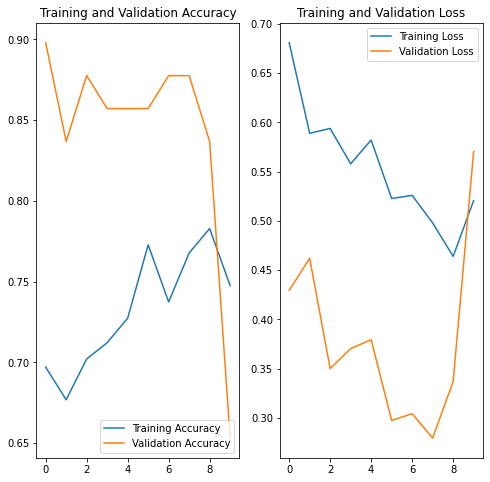

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [28]:
test_folder_pass = "./testimages/"
test_folder_pass


'./testimages/'

In [29]:
import os
for file in os.listdir(test_folder_pass):
    if file!=".DS_Store":
    
        img = keras.preprocessing.image.load_img(test_folder_pass+file, target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)

        #using softmax to calculate the probabilities:
        score = np.exp(predictions) / np.sum(np.exp(predictions))

        print(f'With a probility of {int(np.max(score)*100)} percent, "{file}" belongs to "{class_names[np.argmax(score)]}".')

With a probility of 71 percent, "Y1.jpg" belongs to "yes".
With a probility of 82 percent, "34 no.jpg" belongs to "no".
With a probility of 68 percent, "Y11.jpg" belongs to "yes".
With a probility of 59 percent, "Y14.jpg" belongs to "yes".
With a probility of 81 percent, "29 no.jpg" belongs to "no".
With a probility of 87 percent, "48 no.jpeg" belongs to "no".


### References

[1- Keras Computer vision](https://keras.io/examples/vision/)

[2- Kaggle Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)